In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
from astropy.wcs import WCS
from astropy.io import fits
from scipy.optimize import curve_fit, root_scalar
from spectral_cube import SpectralCube
from lmfit import Model, Parameters
from scipy.interpolate import interp1d
import aplpy

In [3]:
warnings.filterwarnings('ignore')

# Constants
etamb = 0.89
etaf = 1.0
nu11 = 23.6944955e9
nu22 = 23.7226333e9
h = 6.62606896e-34
kB = 1.3806504e-23
Tbg = 2.73
c = 2.99792458e8
To = 41.5
epsilon = 8.854187817e-12
dipole = 298117.06e6
C_moment = 186726.36e6
mu = 1.476 * 3.336e-30
mu11 = mu ** 2 * (1. / 2.)
Einstein_A = (16. * np.pi ** 3 / (3. * epsilon * h * c ** 3)) * nu11 ** 3 * abs(mu11)
J_Tbg = h * nu11 / kB * (1. / (np.exp(h * nu11 / (kB * Tbg)) - 1))
etac = etamb * etaf
mNH3=17.03      #amu
mH=1.00794      #amu
amu=1.66053886e-27  #kg

In [4]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def quad_func(x, amp0, vel0, sigma0, tau0): # (1,1) Single-gaussian profile
    amp = [0.226, 0.273, 1.0, 0.277, 0.219] # Relative expected amplitudes of five-finger structure
    vel = [-19.503, -7.594, 0.0, 7.599, 19.493] # Relative expected velocities of five-finger structure
    emission_profile = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0)) # Amplitude of gaussian is ratio of main/sattelite line amplitudes
        emission_profile += gaussian(x, Tq, vel0 + veli, sigma0)
    return amp0*emission_profile

def quad_func2c(x, amp0, vel0, sigma0, tau0, amp1, vel1, sigma1, tau1): # (1,1) Double-gaussian
    amp = [0.226, 0.273, 1.0, 0.277, 0.219]
    vel = [-19.503, -7.594, 0.0, 7.599, 19.493]

    emission_profile0 = np.zeros_like(x)
    emission_profile1 = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq0=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0))
        Tq1=(1-np.exp(-ampi*tau1))/(1-np.exp(-tau1))
        emission_profile0 += gaussian(x, Tq0, vel0 + veli, sigma0)
        emission_profile1 += gaussian(x, Tq1, vel1 + veli, sigma1)
    return amp0*emission_profile0+amp1*emission_profile1

def quad_func22(x, amp0, vel0, sigma0, tau0): # (2,2) Single-gaussian profile
    amp = [0.063, 0.039, 1.0, 0.092, 0.063]
    vel = [-26.023, -16.368, 0.0, 16.368, 26.023]

    emission_profile = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0))
        emission_profile += gaussian(x, Tq, vel0 + veli, sigma0)
    return amp0*emission_profile

def quad_func222c(x, amp0, vel0, sigma0, tau0, amp1, vel1, sigma1, tau1): # (2,2) Double-gaussian profile
    amp = [0.063, 0.039, 1.0, 0.092, 0.063]
    vel = [-26.023, -16.368, 0.0, 16.368, 26.023]

    emission_profile0 = np.zeros_like(x)
    emission_profile1 = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq0=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0))
        Tq1=(1-np.exp(-ampi*tau1))/(1-np.exp(-tau1))
        emission_profile0 += gaussian(x, Tq0, vel0 + veli, sigma0)
        emission_profile1 += gaussian(x, Tq1, vel1 + veli, sigma1)
    return amp0*emission_profile0+amp1*emission_profile1

def solve_Tk(Tr): # Solve for kinetic temperature Tk given rotational temperature Tr
    if np.isnan(Tr):
        return np.nan

    def KineticTemp(Tk):
        if Tk <= 0:
            return 1e6  # prevent log or exp issues
        return Tk / (1. + ((Tk / To) * np.log(1. + (0.6 * np.exp(-15.7 / Tk))))) - Tr

    try:
        sol = root_scalar(KineticTemp, bracket=[1, 500], method='brentq')
        return sol.root if sol.converged else np.nan
    except Exception:
        return np.nan

In [5]:
# File paths
# path = '/home/scratch/lmorgan/Projects/GalacticBar/'
path = '/users/hfwest/GBO-REU/'
# datadir = path+'Data/Pilot_All/Pilot_All/FitResults/'
datadir = path + 'NH3-Results/'
suffixout='_test'
Cube11 = SpectralCube.read(path + 'Data/Pilot_NH3_11_bl2.fits')
Cube22 = SpectralCube.read(path + 'Data/Pilot_NH3_22_bl2.fits')
NComp11_File = path + 'Data/NCompMap11.fits'
NComp11_hdu = fits.open(NComp11_File)[0]
NComp11_wcs = WCS(NComp11_hdu.header)
NComp11_data = NComp11_hdu.data
NComp22_File = path + 'Data/NCompMap22.fits'
NComp22_hdu = fits.open(NComp22_File)[0]
NComp22_wcs = WCS(NComp22_hdu.header)
NComp22_data = NComp22_hdu.data

In [6]:
# Grab the middle channel as a 2D slice
slice2d11 = Cube11[Cube11.spectral_axis.size // 2]
slice2d22 = Cube22[Cube22.spectral_axis.size // 2]

# Get the WCS from the 2D slice
wcs_3d11 = Cube11.wcs
wcs_3d22 = Cube22.wcs
wcs_2d11 = slice2d11.wcs
wcs_2d22 = slice2d22.wcs

# Convert to header
header_3d11 = wcs_3d11.to_header()
header_3d22 = wcs_3d22.to_header()
header_2d11 = wcs_2d11.to_header()
header_2d22 = wcs_2d22.to_header()

# Optionally: copy over some key metadata from the original header
for key in ['BUNIT', 'OBJECT', 'TELESCOP', 'DATE-OBS']:
    if key in Cube11.header:
        header_2d11[key] = Cube11.header[key]
    if key in Cube22.header:
        header_2d22[key] = Cube22.header[key]

vmargin = 50.
threshold = 5   # N sigma level to fit above
thresholdlower = 3   # N sigma level to fit secondary/tertiary components above
vl = 140 * u.km / u.s    # Within bounds of observed emission TODO: adjust if adapting to RAMPS data
vh = 260 * u.km / u.s
rmsvl = 280 * u.km / u.s    # Outside bounds of observed emission TODO: adjust if adapting to RAMPS data
rmsvh = 320 * u.km / u.s
# Reference pixel (adjusted for Python's 0-indexing)
xpeak = 83      # v.strong
ypeak = 79
xpeak = 105     # clear two-component area
ypeak = 62
xpeak = 98      # hopefully simple pixel
ypeak = 84
xpeak = 52     # probable non-detection
ypeak = 115
xpeak = 91     # potential three-component area
ypeak = 74
ref_pixx = xpeak - 1
ref_pixy = ypeak - 1

In [7]:
Cube11 = Cube11.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nu11*u.Hz)
Cube22 = Cube22.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nu22*u.Hz)

Cube11_slab = Cube11.spectral_slab(vl, vh)
RMS11_slab = Cube11.spectral_slab(rmsvl, rmsvh)
vel_axis11 = Cube11_slab.spectral_axis # Range of velocities considered
cube11_data = Cube11_slab.unmasked_data[:].value
rms11_data = RMS11_slab.unmasked_data[:].value

Cube22_slab = Cube22.spectral_slab(vl, vh)
RMS22_slab = Cube22.spectral_slab(rmsvl, rmsvh)
vel_axis22 = Cube22_slab.spectral_axis
cube22_data = Cube22_slab.unmasked_data[:].value
rms22_data = RMS22_slab.unmasked_data[:].value

ny, nx = Cube11.shape[1], Cube11.shape[2]
nz = vel_axis11.shape[0]

TMaxMap11 = np.zeros((ny, nx))
TMaxMap22 = np.zeros((ny, nx))
TauMap11 = np.zeros((ny, nx))
SigmaMap11 = np.zeros((ny, nx))
SigmaMap22 = np.zeros((ny, nx))
VelMap11 = np.zeros((ny, nx))
VelMap22 = np.zeros((ny, nx))
TempRotMap = np.zeros((ny, nx))
TempExMap = np.zeros((ny, nx))
TempKinMap = np.zeros((ny, nx))
FFMap = np.zeros((ny, nx))
NColMap = np.zeros((ny, nx))
Sigma_Therm_Map = np.zeros((ny, nx))
Sigma_Turb_Map11 = np.zeros((ny, nx))
Sigma_Turb_Map22 = np.zeros((ny, nx))
TMaxMap11Comp1 = np.zeros((ny, nx))
TMaxMap11Comp2 = np.zeros((ny, nx))
SigmaMap11Comp1 = np.zeros((ny, nx))
SigmaMap11Comp2 = np.zeros((ny, nx))
VelMap11Comp1 = np.zeros((ny, nx))
VelMap11Comp2 = np.zeros((ny, nx))
TMaxMap22Comp1 = np.zeros((ny, nx))
TMaxMap22Comp2 = np.zeros((ny, nx))
SigmaMap22Comp1 = np.zeros((ny, nx))
SigmaMap22Comp2 = np.zeros((ny, nx))
VelMap22Comp1 = np.zeros((ny, nx))
VelMap22Comp2 = np.zeros((ny, nx))
ResidMap11 = np.zeros((ny, nx))
ResidMap22 = np.zeros((ny, nx))
ResidCube11 = np.zeros((nz, ny, nx))
ResidCube22 = np.zeros((nz, ny, nx))
RedChiMap11 = np.zeros((ny, nx))
RedChiMap22 = np.zeros((ny, nx))

modelq = Model(quad_func)
modelq2c = Model(quad_func2c)
modelq22 = Model(quad_func22)
modelq222c = Model(quad_func222c)

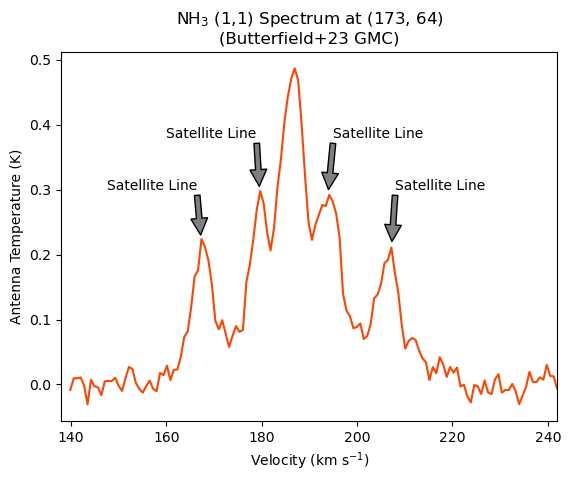

In [71]:
plt.plot(list(np.array(vel_axis11).astype(float)), cube11_data[:, 64, 173], label='Cube11 Data', color = 'orangered') # Indexed as (z, y, x)
plt.xticks()
plt.xlabel('Velocity (km s$^{-1}$)')
plt.ylabel('Antenna Temperature (K)')
plt.title('NH$_3$ (1,1) Spectrum at (173, 64)\n(Butterfield+23 GMC)')
plt.xlim(138, 242)
plt.annotate('Satellite Line', xy = (167.2, .23), xytext = (147.5, .3), arrowprops = dict(facecolor='gray', shrink=0.00005))
plt.annotate('Satellite Line', xy = (179.5, .305), xytext = (160, .38), arrowprops = dict(facecolor='gray', shrink=0.00005))
plt.annotate('Satellite Line', xy = (194, .3), xytext = (195, .38), arrowprops = dict(facecolor='gray', shrink=0.00005))
plt.annotate('Satellite Line', xy = (207.3, .22), xytext = (208, .3), arrowprops = dict(facecolor='gray', shrink=0.00005))
# plt.show()
plt.savefig('/users/hfwest/GBO-REU/Plots/Example-spectrum-11.png', dpi=300, bbox_inches='tight')

In [ ]:
# for j in range(ny):
#     for i in range(nx):
#         spec11 = cube11_data[:, j, i] # Full spectrum at pixel (i,j)
#         rms11 = np.std(rms11_data[:, j, i])  # emission-free region of spectrum gives baseline value
#         testmaxindex11 = np.argmax(spec11)          # Index of velocity corresponding to largest peak in (1,1) spectrum
#         testvel_peak11 = vel_axis11[testmaxindex11] # Velocity corresponding to largest peak in (1,1) spectrum
#         amp011 = spec11[testmaxindex11]             # Height of largest peak in (1,1) spectrum

#         # Repeat for (2,2) spectrum
#         spec22 = cube22_data[:, j, i]
#         rms22 = np.std(rms22_data[:, j, i])
#         testmaxindex22 = np.argmax(spec22)
#         testvel_peak22 = vel_axis22[testmaxindex22]
#         amp022 = spec22[testmaxindex22]

#         if amp011 > threshold * rms11: # If peak of (1,1) spectrum is greater than 5 sigma above the baseline

#             #RMS is fairly uniform at around 0.011 across most of the map
#             #The overlapping region has an RMS of ~0.013, maxing out at ~0.02
            
#             mask11 = (vel_axis11.value > testvel_peak11.value - vmargin) & (vel_axis11.value < testvel_peak11.value + vmargin)
#             # Value mask: velocities within |vmargin| distance of the peak velocity. In this case, vmargin = 50 km/s
#             vel_axis11_clip = vel_axis11[mask11]
#             spec11_clip = spec11[mask11]
#             # velocities and spectra for masked range (+- vmargin from peak) at this pixel

#             # fig11=plt.figure(figsize=(10,7))
#             # ax11=fig11.add_subplot(111)
#             # ax11.plot(vel_axis11,spec11)
#             # ax11.plot(vel_axis11_clip,spec11_clip,color='black')
#             # plt.show()


#             # Single gaussian solution parameters:
#             paramsq11 = Parameters()
#             paramsq11.add('amp0', value=amp011, min=threshold * rms11)
#             paramsq11.add('vel0', value=testvel_peak11.value)
#             paramsq11.add('sigma0', value=1.0, min=0.01)
#             paramsq11.add('tau0', value=1.5, max=20, min=0.1)

#             # Double gaussian solution parameters:
#             paramsq112c = Parameters()
#             paramsq112c.add('amp0', value=amp011, min=threshold * rms11)
#             paramsq112c.add('vel0', value=testvel_peak11.value)
#             paramsq112c.add('sigma0', value=1.0, min=0.01)
#             paramsq112c.add('tau0', value=1.5, max=20, min=0.01)
#             paramsq112c.add('amp1', value=amp011*0.8, min=thresholdlower * rms11)
#             paramsq112c.add('vel1', value=testvel_peak11.value+5)
#             paramsq112c.add('sigma1', value=1.0, min=0.01)
#             paramsq112c.add('tau1', value=1.0, max=20, min=0.1)

#             if NComp11_data[j,i] == 2 and NComp22_data[j,i] == 2:
#                 resultq112c = modelq2c.fit(spec11_clip, paramsq112c, x=vel_axis11_clip.value)
#                 if resultq112c.params['amp0'].value < resultq112c.params['amp1'].value:
#                     SigmaMap11[j,i] = resultq112c.params['sigma1'].value
#                     VelMap11[j,i] = resultq112c.params['vel1'].value
#                     TMaxMap11Comp1[j,i] = resultq112c.params['amp1'].value
#                     TMaxMap11Comp2[j,i] = resultq112c.params['amp0'].value
#                     SigmaMap11Comp1[j,i] = resultq112c.params['sigma1'].value
#                     SigmaMap11Comp2[j,i] = resultq112c.params['sigma0'].value
#                     VelMap11Comp1[j,i] = resultq112c.params['vel1'].value
#                     VelMap11Comp2[j,i] = resultq112c.params['vel0'].value
#                 else:
#                     SigmaMap11[j,i] = resultq112c.params['sigma0'].value
#                     VelMap11[j,i] = resultq112c.params['vel0'].value
#                     TMaxMap11Comp1[j,i] = resultq112c.params['amp0'].value
#                     TMaxMap11Comp2[j,i] = resultq112c.params['amp1'].value
#                     SigmaMap11Comp1[j,i] = resultq112c.params['sigma0'].value
#                     SigmaMap11Comp2[j,i] = resultq112c.params['sigma1'].value
#                     VelMap11Comp1[j,i] = resultq112c.params['vel0'].value
#                     VelMap11Comp2[j,i] = resultq112c.params['vel1'].value
#                 InterpResid11 = interp1d(vel_axis11_clip, resultq112c.residual, bounds_error=False, fill_value=0.0)
#                 ResidCube11[:,j,i] = InterpResid11(vel_axis11)
#                 ResidMap11[j,i] = np.sqrt(np.mean(resultq112c.residual**2))
#                 RedChiMap11[j,i] = resultq112c.redchi

#                 Tau11_main = resultq112c.params['tau0'].value+resultq112c.params['tau1'].value
#                 TMax11 = np.nanmax([resultq112c.params['amp0'].value,resultq112c.params['amp1'].value])
#             elif NComp11_data[j,i] != 0:
#                 resultq11 = modelq.fit(spec11_clip, paramsq11, x=vel_axis11_clip.value)
#                 Tau11_main = resultq11.params['tau0'].value
#                 TMax11 = resultq11.params['amp0'].value
#                 SigmaMap11[j,i] = resultq11.params['sigma0'].value
#                 VelMap11[j,i] = resultq11.params['vel0'].value
#                 TMaxMap11Comp1[j,i] = resultq11.params['amp0'].value
#                 SigmaMap11Comp1[j,i] = resultq11.params['sigma0'].value
#                 VelMap11Comp1[j,i] = resultq11.params['vel0'].value
#                 InterpResid11 = interp1d(vel_axis11_clip, resultq11.residual, bounds_error=False, fill_value=0.0)
#                 ResidCube11[:,j,i] = InterpResid11(vel_axis11)
#                 ResidMap11[j,i] = np.sqrt(np.mean(resultq11.residual**2))
#                 RedChiMap11[j,i] = resultq11.redchi
#             else: # Implicitly 'if NComp11_data[j,i] == 0', hence don't fit a gaussian
#                 Tau11_main = 0.0
#                 TMax11 = 0.0
#             TauMap11[j,i] = Tau11_main * 1.995 # (1,1 quadrupoles are 0.226, 0.273, 0.277, 0.219, sum = 0.995 of the main height, so the total is 1.995 and the ratio of the main line to the total is 1/1.995)
#             TMaxMap11[j,i] = TMax11

#         if amp022 > thresholdlower * rms22: # If peak of (2,2) spectrum is greater than 3 sigma above the baseline
            
#             #RMS is fairly uniform at around 0.011 across most of the map
#                         #The overlapping region has an RMS of ~0.013, maxing out at ~0.02
#             mask22 = (vel_axis22.value > testvel_peak11.value - vmargin) & (vel_axis22.value < testvel_peak11.value + vmargin)
#             vel_axis22_clip = vel_axis22[mask22]
#             spec22_clip = spec22[mask22]

#             paramsq22 = Parameters()
#             paramsq22.add('amp0', value=amp022, min=thresholdlower * rms22)
#             paramsq22.add('vel0', value=testvel_peak11.value)
#             paramsq22.add('sigma0', value=1.0, min=0.01)
#             paramsq22.add('tau0', value=1.5, max=20, min=0.1)

#             paramsq222c = Parameters()
#             paramsq222c.add('amp0', value=amp022, min=thresholdlower * rms22)
#             paramsq222c.add('vel0', value=testvel_peak22.value)
#             paramsq222c.add('sigma0', value=1.0, min=0.01)
#             paramsq222c.add('tau0', value=1.5, max=20, min=0.01)
#             paramsq222c.add('amp1', value=amp022*0.8, min=thresholdlower * rms22)
#             paramsq222c.add('vel1', value=testvel_peak22.value+5)
#             paramsq222c.add('sigma1', value=1.0, min=0.01)
#             paramsq222c.add('tau1', value=1.0, max=20, min=0.1)

#             if NComp22_data[j,i] == 2 and NComp11_data[j,i] == 2:
#                 resultq222c = modelq222c.fit(spec22_clip, paramsq222c, x=vel_axis22_clip.value)
#                 TMax22 = np.nanmax([resultq222c.params['amp0'].value,resultq222c.params['amp1'].value])
#                 if resultq222c.params['amp0'].value < resultq222c.params['amp1'].value:
#                     SigmaMap22[j,i] = resultq222c.params['sigma1'].value
#                     VelMap22[j,i] = resultq222c.params['vel1'].value
#                     SigmaMap22Comp1[j,i] = resultq222c.params['sigma1'].value
#                     SigmaMap22Comp2[j,i] = resultq222c.params['sigma0'].value
#                     VelMap22Comp1[j,i] = resultq222c.params['vel1'].value
#                     VelMap22Comp2[j,i] = resultq222c.params['vel0'].value
#                     TMaxMap22Comp1[j,i] = resultq222c.params['amp1'].value
#                     TMaxMap22Comp2[j,i] = resultq222c.params['amp0'].value
#                 else:
#                     SigmaMap22[j,i] = resultq222c.params['sigma0'].value
#                     VelMap22[j,i] = resultq222c.params['vel0'].value
#                     SigmaMap22Comp1[j,i] = resultq222c.params['sigma0'].value
#                     SigmaMap22Comp2[j,i] = resultq222c.params['sigma1'].value
#                     VelMap22Comp1[j,i] = resultq222c.params['vel0'].value
#                     VelMap22Comp2[j,i] = resultq222c.params['vel1'].value
#                     TMaxMap22Comp1[j,i] = resultq222c.params['amp0'].value
#                     TMaxMap22Comp2[j,i] = resultq222c.params['amp1'].value
#                 InterpResid22 = interp1d(vel_axis22_clip, resultq222c.residual, bounds_error=False, fill_value=0.0)
#                 ResidCube22[:,j,i] = InterpResid22(vel_axis22)
#                 ResidMap22[j,i] = np.sqrt(np.mean(resultq222c.residual**2))
#                 RedChiMap22[j,i] = resultq222c.redchi
#             elif NComp22_data[j,i] != 0:
#                 resultq22 = modelq22.fit(spec22_clip, paramsq22, x=vel_axis22_clip.value)
#                 TMax22 = resultq22.params['amp0'].value
#                 SigmaMap22[j,i] = resultq22.params['sigma0'].value
#                 VelMap22[j,i] = resultq22.params['vel0'].value
#                 VelMap22Comp1[j,i] = resultq22.params['vel0'].value
#                 TMaxMap22Comp1[j,i] = resultq22.params['amp0'].value
#                 SigmaMap22Comp1[j,i] = resultq22.params['sigma0'].value
#                 InterpResid22 = interp1d(vel_axis22_clip, resultq22.residual, bounds_error=False,fill_value=0.0)
#                 ResidCube22[:,j,i] = InterpResid22(vel_axis22)
#                 ResidMap22[j,i] = np.sqrt(np.mean(resultq22.residual**2))
#                 RedChiMap22[j,i] = resultq22.redchi
#             else:
#                 TMax22 = 0.0
#             TMaxMap22[j,i] = TMax22

#         Tr = (-1.*To)/(np.log((-0.282/TauMap11[j,i]/1.995)*np.log(1.-((TMaxMap22[j,i]/TMaxMap11[j,i])*(1.-np.exp(-1.*TauMap11[j,i]/1.995))))))
#         TempRotMap[j,i] = Tr

#         Tk = solve_Tk(Tr)
#         TempKinMap[j,i] = Tk
#         B=1.-np.exp(-1.*TauMap11[j,i]/1.995)
#         TempExMap[j,i] = h*nu11/(kB*np.log((h*nu11/kB)*(1./(TMaxMap11[j,i]/(etac*B)+J_Tbg)+1)))
# #Calculate filling factor by setting Tex=Tkin
#         J_Tkin=h*nu11/kB*(1./((np.exp(h*nu11/(kB*Tk)))-1))
#         FFMap[j,i]=TMaxMap11[j,i]/(etamb*(J_Tkin-J_Tbg)*B)
#         Sigma_Therm_Map[j,i]=((8.*kB*Tk*np.log(2.)/(mNH3*amu))**0.5)/1000.
#         Sigma_Turb_Map11[j,i]=((SigmaMap11[j,i]**2.)-(Sigma_Therm_Map[j,i]**2.))**0.5
#         Sigma_Turb_Map22[j,i]=((SigmaMap22[j,i]**2.)-(Sigma_Therm_Map[j,i]**2.))**0.5

# #Calculating column density - using sigma, not dV
#         N11=(8.*np.pi*(nu11**2.)/c**2.)*(1./Einstein_A)*((1.+np.exp(-1.*(h*nu11/(kB*Tk))))/(1.-np.exp(-1.*(h*nu11/(kB*Tk)))))*(np.sqrt(2.*np.pi))*(np.sqrt(((SigmaMap11[j,i]*1e3)**2)/(8.*np.log(2))))*(nu11/c)*TauMap11[j,i]/1e4

#         # No. of states to sum over for partition function, 10 is more than sufficient
#         Z_tot=0.
#         Nstates=10
#         for jstate in range(1,Nstates):
#         # ortho=0,3,6,9...
#         # if (jstate mod 3) ne 0 then state is para- (J=1,2,4,5...)
#             if (jstate % 3) != 0:
#                 S=1
#             else:
#                 S=0
#             Z=(2.*jstate+1.)*S*np.exp(-1.*(h/(kB*Tk))*((dipole*jstate*(jstate+1))+((C_moment-dipole)*jstate**2)))
#             Z_tot=Z_tot+Z
#         Z_11=3.*np.exp(-1.*h*(dipole+C_moment)/(kB*Tk))
#         NColMap[j,i] = np.log(N11*Z_tot/Z_11) # Only 1 column density map created, corresponding only to (1,1) line

In [8]:
# Tau11hdu = fits.PrimaryHDU(TauMap11, header=header_2d11)
# Tau11hdu.writeto(datadir+'Pilot_NH3_11_bl2_Tau11'+suffixout+'.fits', overwrite=True)
# TMax11hdu = fits.PrimaryHDU(TMaxMap11, header=header_2d11)
# TMax11hdu.writeto(datadir+'Pilot_NH3_11_bl2_Max11'+suffixout+'.fits', overwrite=True)
# TMax22hdu = fits.PrimaryHDU(TMaxMap22, header=header_2d11)
# TMax22hdu.writeto(datadir+'Pilot_NH3_11_bl2_Max22'+suffixout+'.fits', overwrite=True)
# Sigma11hdu = fits.PrimaryHDU(SigmaMap11, header=header_2d11)
# Sigma11hdu.writeto(datadir+'Pilot_NH3_11_bl2_Sigma11'+suffixout+'.fits', overwrite=True)
# Sigma22hdu = fits.PrimaryHDU(SigmaMap22, header=header_2d11)
# Sigma22hdu.writeto(datadir+'Pilot_NH3_11_bl2_Sigma22'+suffixout+'.fits', overwrite=True)
# Vel11hdu = fits.PrimaryHDU(VelMap11, header=header_2d11)
# Vel11hdu.writeto(datadir+'Pilot_NH3_11_bl2_Vel11'+suffixout+'.fits', overwrite=True)
# Vel22hdu = fits.PrimaryHDU(VelMap22, header=header_2d11)
# Vel22hdu.writeto(datadir+'Pilot_NH3_11_bl2_Vel22'+suffixout+'.fits', overwrite=True)
# TRothdu = fits.PrimaryHDU(TempRotMap, header=header_2d11)
# TRothdu.writeto(datadir+'Pilot_NH3_11_bl2_TRot'+suffixout+'.fits', overwrite=True)
# TExhdu = fits.PrimaryHDU(TempExMap, header=header_2d11)
# TExhdu.writeto(datadir+'Pilot_NH3_11_bl2_TEx'+suffixout+'.fits', overwrite=True)
# TKhdu = fits.PrimaryHDU(TempKinMap, header=header_2d11)
# TKhdu.writeto(datadir+'Pilot_NH3_11_bl2_Tk'+suffixout+'.fits', overwrite=True)
# FFhdu = fits.PrimaryHDU(FFMap, header=header_2d11)
# FFhdu.writeto(datadir+'Pilot_NH3_11_bl2_FF'+suffixout+'.fits', overwrite=True)
# NColhdu = fits.PrimaryHDU(NColMap, header=header_2d11)
# NColhdu.writeto(datadir+'Pilot_NH3_11_bl2_NCol'+suffixout+'.fits', overwrite=True)
# SigmaTherm11hdu = fits.PrimaryHDU(Sigma_Therm_Map, header=header_2d11)
# SigmaTherm11hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaTherm11'+suffixout+'.fits', overwrite=True)
# SigmaTurb11hdu = fits.PrimaryHDU(Sigma_Turb_Map11, header=header_2d11)
# SigmaTurb11hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaTurb11'+suffixout+'.fits', overwrite=True)
# SigmaTurb22hdu = fits.PrimaryHDU(Sigma_Turb_Map22, header=header_2d11)
# SigmaTurb22hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaTurb22'+suffixout+'.fits', overwrite=True)
# TMaxMap11Comp1hdu = fits.PrimaryHDU(TMaxMap11Comp1, header=header_2d11)
# TMaxMap11Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_TMaxMap11Comp1'+suffixout+'.fits', overwrite=True)
# TMaxMap11Comp2hdu = fits.PrimaryHDU(TMaxMap11Comp2, header=header_2d11)
# TMaxMap11Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_TMaxMap11Comp2'+suffixout+'.fits', overwrite=True)
# SigmaMap11Comp1hdu = fits.PrimaryHDU(SigmaMap11Comp1, header=header_2d11)
# SigmaMap11Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaMap11Comp1'+suffixout+'.fits', overwrite=True)
# SigmaMap11Comp2hdu = fits.PrimaryHDU(SigmaMap11Comp2, header=header_2d11)
# SigmaMap11Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaMap11Comp2'+suffixout+'.fits', overwrite=True)
# VelMap11Comp1hdu = fits.PrimaryHDU(VelMap11Comp1, header=header_2d11)
# VelMap11Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_VelMap11Comp1'+suffixout+'.fits', overwrite=True)
# VelMap11Comp2hdu = fits.PrimaryHDU(VelMap11Comp2, header=header_2d11)
# VelMap11Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_VelMap11Comp2'+suffixout+'.fits', overwrite=True)
# TMaxMap22Comp1hdu = fits.PrimaryHDU(TMaxMap22Comp1, header=header_2d11)
# TMaxMap22Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_TMaxMap22Comp1'+suffixout+'.fits', overwrite=True)
# TMaxMap22Comp2hdu = fits.PrimaryHDU(TMaxMap22Comp2, header=header_2d11)
# TMaxMap22Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_TMaxMap22Comp2'+suffixout+'.fits', overwrite=True)
# SigmaMap22Comp1hdu = fits.PrimaryHDU(SigmaMap22Comp1, header=header_2d11)
# SigmaMap22Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaMap22Comp1'+suffixout+'.fits', overwrite=True)
# SigmaMap22Comp2hdu = fits.PrimaryHDU(SigmaMap22Comp2, header=header_2d11)
# SigmaMap22Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_SigmaMap22Comp2'+suffixout+'.fits', overwrite=True)
# VelMap22Comp1hdu = fits.PrimaryHDU(VelMap22Comp1, header=header_2d11)
# VelMap22Comp1hdu.writeto(datadir+'Pilot_NH3_11_bl2_VelMap22Comp1'+suffixout+'.fits', overwrite=True)
# VelMap22Comp2hdu = fits.PrimaryHDU(VelMap22Comp2, header=header_2d11)
# VelMap22Comp2hdu.writeto(datadir+'Pilot_NH3_11_bl2_VelMap22Comp2'+suffixout+'.fits', overwrite=True)
# ResidMap11hdu = fits.PrimaryHDU(ResidMap11, header=header_2d11)
# ResidMap11hdu.writeto(datadir+'Pilot_NH3_11_bl2_ResidMap11'+suffixout+'.fits', overwrite=True)
# ResidMap22hdu = fits.PrimaryHDU(ResidMap22, header=header_2d11)
# ResidMap22hdu.writeto(datadir+'Pilot_NH3_11_bl2_ResidMap22'+suffixout+'.fits', overwrite=True)
# RedChiMap11hdu = fits.PrimaryHDU(RedChiMap11, header=header_2d11)
# RedChiMap11hdu.writeto(datadir+'Pilot_NH3_11_bl2_RedChiMap11'+suffixout+'.fits', overwrite=True)
# RedChiMap22hdu = fits.PrimaryHDU(RedChiMap22, header=header_2d11)
# RedChiMap22hdu.writeto(datadir+'Pilot_NH3_11_bl2_RedChiMap22'+suffixout+'.fits', overwrite=True)
# ResidCube11hdu = fits.PrimaryHDU(ResidCube11, header=header_3d11)
# ResidCube11hdu.writeto(datadir+'Pilot_NH3_11_bl2_ResidCube11'+suffixout+'.fits', overwrite=True)
# ResidCube22hdu = fits.PrimaryHDU(ResidCube22, header=header_3d22)
# ResidCube22hdu.writeto(datadir+'Pilot_NH3_11_bl2_ResidCube22'+suffixout+'.fits', overwrite=True)


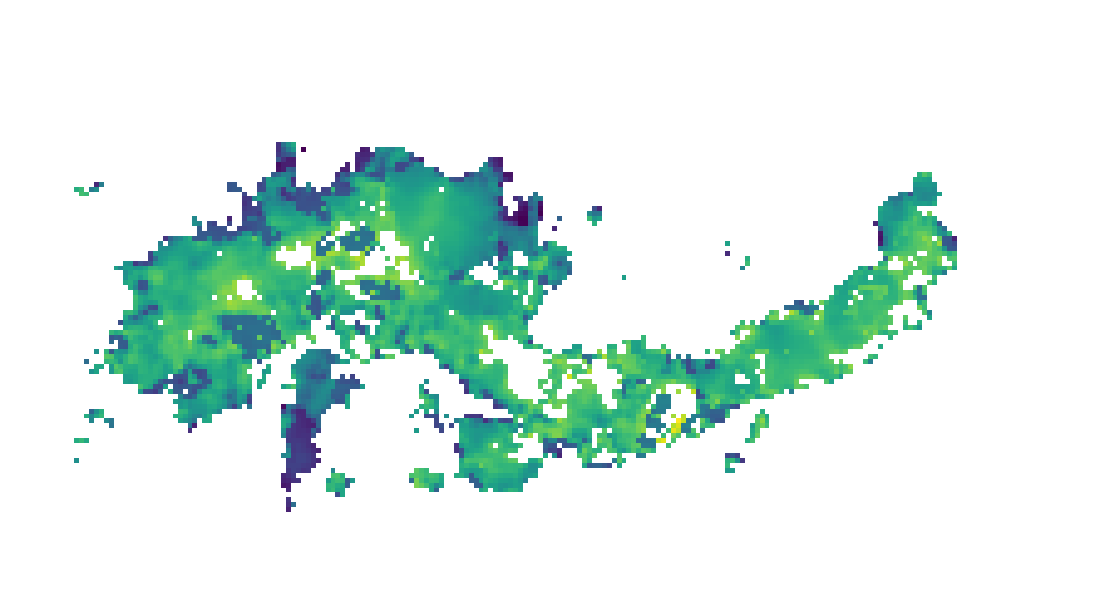

In [16]:
test = fits.PrimaryHDU(fits.getdata('/users/hfwest/GBO-REU/NH3-Results/Pilot_NH3_11_bl2_NCol_test.fits'))
fig, ax = plt.subplots(figsize=(14, 10))
plt.imshow(test.data)
ax.invert_yaxis()
plt.axis('off');